# Import Library

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from pyod.models.lof import LOF
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [2]:
DATA_DIR = '/Users/andishetavakkoli/Documents/notebook/github_project/machine-learning-projects-data/fraud_detection'

In [3]:
df = pd.read_csv(DATA_DIR + '/PS_20174392719_1491204439457_log.csv')

In [4]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [5]:
df.groupby('type')['isFraud'].sum()

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64

In [6]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

# zscore

If the z score of a data point is more than 3 (because it cover 99.7% of area), it indicates that the data value is quite different from the other values. It is taken as outliers.

In [7]:
def z_score(series, outlier=None, zscore=None):
    outlier_list = []
    mean = np.mean(series)
    std = np.mean(series)

    zscore_list = []
    for item in series:
        z = (item - mean) / std
        zscore_list.append(z)

        if np.abs(z) > 100:
            outlier_list.append(item) 
    if zscore == True:
        return zscore_list
    if outlier == True:
        return outlier_list

    

In [8]:
len(z_score(df['amount'], outlier=True))

989

In [9]:
df.kurtosis()

step                   0.329071
amount              1797.956705
oldbalanceOrg         32.964879
newbalanceOrig        32.066985
oldbalanceDest       948.674125
newbalanceDest       862.156508
isFraud              769.702982
isFlaggedFraud    397659.062500
dtype: float64

In [10]:
df['zscore'] = z_score(df['amount'], zscore=True)

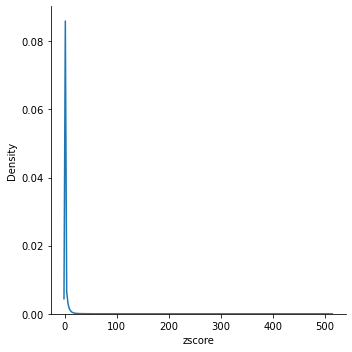

In [71]:
sns.displot(data=df, x='zscore', kind='kde')

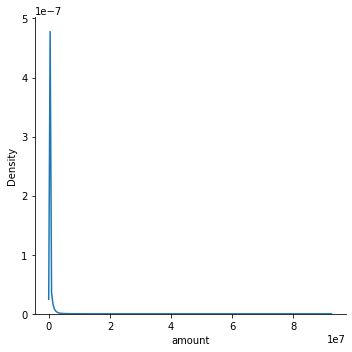

In [60]:
sns.displot(data=df, x='amount', kind='kde')

<AxesSubplot:xlabel='isFraud', ylabel='count'>

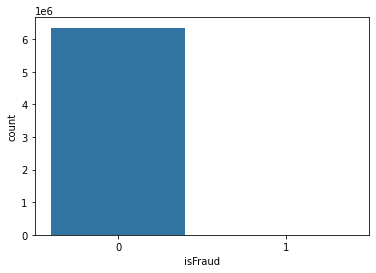

In [24]:
sns.countplot(df, x='isFraud')

# Dimention Reduction

### PCA

<AxesSubplot:xlabel='0', ylabel='1'>

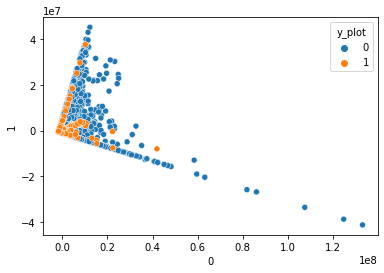

In [74]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_plot)
df_new = pd.DataFrame(X_2d)
df_new['y_plot'] = y_plot.to_list()
sns.scatterplot(x=df_new.iloc[:,0], y=df_new.iloc[:,1] , hue=df_new.iloc[:,2])

### TSNE

In [75]:
tsne = TSNE(n_components=2)
X_2d_ts = tsne.fit_transform(X_plot)

<AxesSubplot:xlabel='0', ylabel='1'>

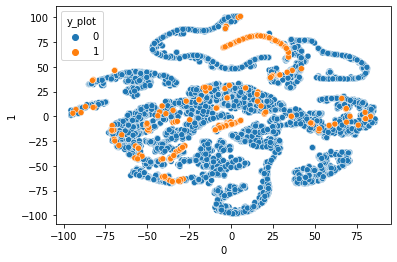

In [76]:
df_new_ts = pd.DataFrame(X_2d_ts)
df_new_ts['y_plot'] = y_plot.to_list()
sns.scatterplot(x=df_new_ts.iloc[:,0], y=df_new_ts.iloc[:,1] , hue=df_new_ts.iloc[:,2])

# Unsupervised Learning

## LocalOutlierFactor

### Select two types of transaction which has been outliers

In [72]:
df = df[df['type'].isin(['CASH_OUT','TRANSFER'])]
df_new = df[[
    'amount',  
    'oldbalanceOrg', 
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'isFraud']]
X = df_new.drop(['isFraud'], axis=1)
y = df_new['isFraud']

### Scaling

In [73]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=21, test_size=0.4, stratify=y)

# modeling
lof = LocalOutlierFactor(n_neighbors=15, contamination=0.1, novelty=True)
lof.fit(X_train)
y_pred = lof.predict(X_test)
y_pred[y_pred == -1] = 1
y_pred[y_pred == 1] = 0
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1104879
           1       0.00      0.00      0.00      3285

    accuracy                           1.00   1108164
   macro avg       0.50      0.50      0.50   1108164
weighted avg       0.99      1.00      1.00   1108164



## LOF with PYOD

In [108]:
lof_pyod = LOF(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination=0.1, n_jobs=1, novelty=True)

In [113]:
lof_pyod.fit(X_train)
y_pred_train = lof_pyod.predict(X_train)

y_pred = lof_pyod.predict(X_test)

In [114]:
df_train = pd.DataFrame(X_train, columns = X.columns)
df_train['is_fraud'] = y_train
df_train['y_pred_py_lof'] = y_pred_train

In [116]:
df_train[df_train['is_fraud'] == 1].shape

(1114, 7)

In [117]:
df_train[df_train['y_pred_py_lof'] == 1].shape

(156232, 7)

In [119]:
df_train[(df_train['is_fraud'] == 1) & (df_train['y_pred_py_lof'] == 1)].shape

(103, 7)

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94   1104879
           1       0.00      0.15      0.01      3285

    accuracy                           0.89   1108164
   macro avg       0.50      0.52      0.48   1108164
weighted avg       0.99      0.89      0.94   1108164



In [112]:
lof_pyod.predict_proba(X_test)

array([[1.00000000e+00, 3.41532146e-12],
       [1.00000000e+00, 2.19750132e-12],
       [1.00000000e+00, 1.31510986e-11],
       ...,
       [1.00000000e+00, 2.23291703e-12],
       [1.00000000e+00, 3.68026520e-12],
       [1.00000000e+00, 5.99561532e-11]])

## Pycaret

In [91]:
from pycaret.anomaly import *

In [76]:
df_train = pd.DataFrame(X, columns = X.columns)

In [77]:
exp_ano101 = setup(X, 
                   normalize = True, 
                   session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(2770409, 5)"
2,Transformed data shape,"(2770409, 5)"
3,Numeric features,5
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


In [78]:
iforest = create_model('iforest')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
models()

In [80]:
iforest_results = assign_model(iforest)
iforest_results.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Anomaly,Anomaly_Score
2,181.000000,181.0,0.0,0.0,0.000000e+00,0,-0.214464
3,181.000000,181.0,0.0,21182.0,0.000000e+00,0,-0.215422
15,229133.937500,15325.0,0.0,5083.0,5.151344e+04,0,-0.228545
19,215310.296875,705.0,0.0,22425.0,0.000000e+00,0,-0.226795
24,311685.875000,10835.0,0.0,6267.0,2.719173e+06,0,-0.200288


In [81]:
iforest_results['Anomaly'].shape

(2770409,)

In [89]:
iforest_results['Anomaly'].sum()

138521

In [83]:
df_train['pycaret_anomaly'] = iforest_results['Anomaly']
df_train['y_train'] = y.to_list()

In [84]:
y_train.shape

(1662245,)

In [85]:
df_train['pycaret_anomaly'].shape

(2770409,)

In [86]:
y_train.value_counts(dropna=False)

0    1657317
1       4928
Name: isFraud, dtype: int64

In [87]:
df_train['y_train'].value_counts(dropna=False)

0    2762196
1       8213
Name: y_train, dtype: int64

In [88]:
df_train[(df_train['pycaret_anomaly'] == 1) & df_train['y_train'] == 1].shape

(3620, 7)

In [93]:
#plot_model(iforest, plot = 'tsne')

In [ ]:
#plot_model(iforest, plot = 'umap')

In [ ]:
# unseen_predictions = predict_model(iforest, data=data_unseen)
# unseen_predictions.head()

In [94]:
# data_predictions = predict_model(iforest, data = data)
# data_predictions.head()

In [ ]:
# save_model(iforest,’Final IForest Model 25Nov2020')

In [ ]:
# saved_iforest = load_model('Final IForest Model 25Nov2020')
# new_prediction = predict_model(saved_iforest, data=data_unseen)
# new_prediction.head()

# Supervised Learning

In [11]:
df = df[df['type'].isin(['CASH_OUT','TRANSFER'])]
df_new = df[[
    'amount',  
    'oldbalanceOrg', 
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'isFraud']]
X = df_new.drop(['isFraud'], axis=1)
y = df_new['isFraud']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.4, stratify=y)

In [17]:
sm = SMOTE()
X_resampled,y_resampled = sm.fit_resample(X_train, y_train)

In [19]:
rf = RandomForestClassifier()
rf.fit(X_resampled,y_resampled)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1104879
           1       0.62      0.96      0.76      3285

    accuracy                           1.00   1108164
   macro avg       0.81      0.98      0.88   1108164
weighted avg       1.00      1.00      1.00   1108164

